In [1]:
import pyLDAvis.gensim
#from pipeline import TopicModeller
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")
from gensim import corpora
#pyLDAvis.enable_notebook()
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel, LdaMulticore
#import tm_functions
import matplotlib.pyplot as plt
%matplotlib inline

import re
import tm_functions

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/midzay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import string
from nltk.corpus import stopwords

In [4]:
stop_words = stopwords.words('russian')
STOPLIST = set(stop_words)
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”","«","»"]

In [5]:
with open('../../../../nlp/preprocessing/stopwords.txt') as sw:
    text =sw.read().splitlines()
for t in text:
    STOPLIST.add(t)
STOPLIST.add('—')

In [6]:
PATH ='/home/midzay/Mlerning/DATASET/proj_news_viz/small/lemma/'
file='biznes.csv.bz2'

In [7]:
data = pd.read_csv(PATH + file , encoding='utf-8')
data.head()

,1914-lenta/,url,edition,topics,title,text,topic,text_lema
0,1999-10-06 12:00:00,https://lenta.ru/news/1999/10/06/caspian_gas/,NaN,Экономика,Туркменистан хочет протянуть газопровод в Турцию,"Как сообщает агентство РИА ""Новости"", главная ...",Бизнес,агентство риа новость главный тема встреча зам...
1,1999-10-11 12:00:00,https://lenta.ru/news/1999/10/11/daewoo/,NaN,Экономика,Daewoo Motor Co. распродает производство автом...,"Автомобили - единственный род продукции, котор...",Бизнес,автомобиль единственный род продукция продолжа...
2,1999-10-11 12:00:00,https://lenta.ru/news/1999/10/11/tupolev/,NaN,Экономика,"Самолет ""Ту-334"" будут строить на МиГе","Как ссобщает газета ""Время MN"" премьер-министр...",Бизнес,ссобщаета газета mn премьер-министр владимир п...
3,1999-10-13 12:00:00,https://lenta.ru/news/1999/10/13/hollywood/,NaN,Экономика,В США закрываются рестораны Planet Hollywood,Компания Planet Hollywood закрыла в минувший в...,Бизнес,planet hollywood закрыть минувший 9 32 рестора...
4,1999-10-13 12:00:00,https://lenta.ru/news/1999/10/13/pm/,NaN,Экономика,Philip Morris признал связь между курением и р...,Концерн Philip Morris Co. во вторник открыл ин...,Бизнес,концерн philip morris co открыть интернет-сайт...


In [8]:
def pre_proc(text):
    tokens = [tok for tok in text.split() if tok not in STOPLIST]
    return tokens
    

In [9]:
data['new_text']=data.text_lema.apply(pre_proc)

In [10]:
data.head()

,1914-lenta/,url,edition,topics,title,text,topic,text_lema,new_text
0,1999-10-06 12:00:00,https://lenta.ru/news/1999/10/06/caspian_gas/,NaN,Экономика,Туркменистан хочет протянуть газопровод в Турцию,"Как сообщает агентство РИА ""Новости"", главная ...",Бизнес,агентство риа новость главный тема встреча зам...,"[агентство, новость, главный, тема, встреча, з..."
1,1999-10-11 12:00:00,https://lenta.ru/news/1999/10/11/daewoo/,NaN,Экономика,Daewoo Motor Co. распродает производство автом...,"Автомобили - единственный род продукции, котор...",Бизнес,автомобиль единственный род продукция продолжа...,"[автомобиль, единственный, род, продукция, про..."
2,1999-10-11 12:00:00,https://lenta.ru/news/1999/10/11/tupolev/,NaN,Экономика,"Самолет ""Ту-334"" будут строить на МиГе","Как ссобщает газета ""Время MN"" премьер-министр...",Бизнес,ссобщаета газета mn премьер-министр владимир п...,"[ссобщаета, газета, mn, премьер-министр, влади..."
3,1999-10-13 12:00:00,https://lenta.ru/news/1999/10/13/hollywood/,NaN,Экономика,В США закрываются рестораны Planet Hollywood,Компания Planet Hollywood закрыла в минувший в...,Бизнес,planet hollywood закрыть минувший 9 32 рестора...,"[planet, hollywood, закрыть, минувший, 9, 32, ..."
4,1999-10-13 12:00:00,https://lenta.ru/news/1999/10/13/pm/,NaN,Экономика,Philip Morris признал связь между курением и р...,Концерн Philip Morris Co. во вторник открыл ин...,Бизнес,концерн philip morris co открыть интернет-сайт...,"[концерн, philip, morris, co, открыть, интерне..."


### Модель

In [11]:
%%time
dictionary = corpora.Dictionary(data['new_text'].values)

CPU times: user 2.67 s, sys: 35.7 ms, total: 2.71 s
Wall time: 2.71 s


In [12]:
%%time
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data['new_text'].values]

CPU times: user 2.24 s, sys: 76 ms, total: 2.32 s
Wall time: 2.33 s


In [13]:
%%time
ldamodel1 = LdaModel(doc_term_matrix, num_topics=15, id2word = dictionary, passes=10, alpha='auto', eta=None, random_state=42)

perplexity = ldamodel1.log_perplexity(doc_term_matrix)
coherence_model_lda = CoherenceModel(model=ldamodel1, texts=data['new_text'].values, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'Perplexity: {perplexity}')
print(f'Coherence Score: {coherence_lda}')

Perplexity: -8.198658154548838
Coherence Score: 0.5523419707575722
CPU times: user 9min 17s, sys: 831 ms, total: 9min 18s
Wall time: 8min 42s


### Топ-топики в текстах

In [14]:
%%time
df_topic_sents_keywords = tm_functions.format_topics_sentences(ldamodel=ldamodel1, corpus=doc_term_matrix,
                                                               texts=data['new_text'].values)

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']



CPU times: user 1min 14s, sys: 144 ms, total: 1min 14s
Wall time: 1min 15s


In [15]:
df_dominant_topic.head(15)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.4252,"проект, строительство, газопровод, россия, пот...","[агентство, новость, главный, тема, встреча, з..."
1,1,9.0,0.4355,"автомобиль, тысяча, машина, продажа, рынок","[автомобиль, единственный, род, продукция, про..."
2,2,11.0,0.3051,"самолёт, гражданский","[ссобщаета, газета, mn, премьер-министр, влади..."
3,3,6.0,0.2922,"доллар, сеть, миллион, составить","[planet, hollywood, закрыть, минувший, 9, 32, ..."
4,4,1.0,0.3038,"производство, миллион","[концерн, philip, morris, co, открыть, интерне..."
5,5,7.0,0.3570,"газпром, газа, миллиард, газ","[двухдневный, визит, казань, председатель, пра..."
6,6,1.0,0.2548,"россия, производство, предприятие, тысяча, мил...","[власть, новокузнецк, администрация, кемеровск..."
7,7,4.0,0.7191,"акция, роснефть, приватизация","[рф, борис, ельцин, подписать, указ, продажа, ..."
8,8,1.0,0.7366,"россия, производитель, российский, рынок, тысяча","[совет, сша, экспорт, домашний, птица, яйцо, u..."
9,9,14.0,0.4444,"авиакомпания, аэрофлот, рейс, перевозка, россия","[аэрофлот, планировать, ближний, повысить, цен..."


### Статистика по топикам

In [16]:
%%time
top_indices = df_topic_sents_keywords.groupby('Dominant_Topic')['Perc_Contribution'].nlargest(1).reset_index()['level_1']
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
condition = df_topic_sents_keywords.index.isin(top_indices)
topic_num_keywords = df_topic_sents_keywords[condition][['Dominant_Topic', 'Topic_Keywords']].reset_index(drop=True)

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

CPU times: user 50.2 ms, sys: 3.97 ms, total: 54.1 ms
Wall time: 199 ms


### График по времени

In [17]:
%%time
data['date'] = data['url'].apply(lambda x: pd.to_datetime('-'.join(x.split('/')[4:7])))
data['year_month'] = data['date'].values.astype('datetime64[M]')

data['topics'] = [ldamodel1.get_document_topics(i) for i in doc_term_matrix]
data['topics_dict'] = data['topics'].apply(lambda x: {i[0]: i[1] for i in x})

for i in range(ldamodel1.num_topics):
    data['topic_' + str(i)] = data['topics_dict'].apply(lambda x: x[i] if i in x.keys() else 0)
    
data = data.sort_values('year_month')

data.loc[data['year_month'] == '1914-09-01 00:00:00', 'year_month'] = pd.Timestamp(year=2014, month=9, day=1, hour=0)

data.to_csv('/home/midzay/Mlerning/DATASET/proj_news_viz/small/update/biznes_update.csv.bz2',compression='bz2', index=False)

CPU times: user 48.3 s, sys: 112 ms, total: 48.4 s
Wall time: 48.5 s


In [18]:
topic_cols = [col for col in data.columns if 'topic_' in col]
a = data.groupby(['year_month'])[topic_cols].mean()#.plot(stacked=True, figsize=(12, 8))

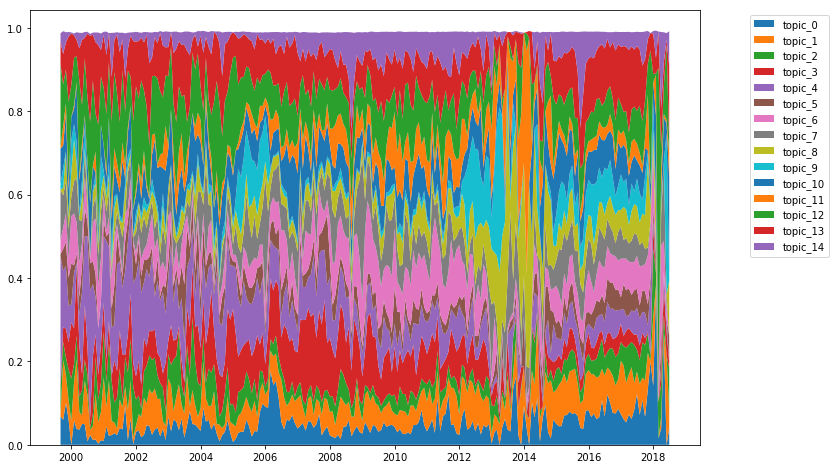

In [19]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.stackplot(a.index, a.T.values, labels=list(a.columns))
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
plt.show()

### Слова в топиках

In [20]:
ldamodel1.print_topics()

[(0,
  '0.023*"проект" + 0.023*"строительство" + 0.011*"газопровод" + 0.010*"россия" + 0.010*"поток" + 0.010*"турецкий" + 0.009*"северный" + 0.008*"турция" + 0.006*"крым" + 0.006*"миллиард"'),
 (1,
  '0.017*"продукция" + 0.015*"россия" + 0.015*"производство" + 0.011*"предприятие" + 0.011*"производитель" + 0.011*"российский" + 0.009*"завод" + 0.009*"рынок" + 0.008*"тысяча" + 0.006*"миллион"'),
 (2,
  '0.011*"бизнес" + 0.010*"российский" + 0.010*"сша" + 0.008*"россия" + 0.008*"международный" + 0.007*"развитие" + 0.007*"форум" + 0.006*"хороший" + 0.006*"мир" + 0.005*"директор"'),
 (3,
  '0.027*"доллар" + 0.026*"акция" + 0.019*"сделка" + 0.016*"миллиард" + 0.013*"миллион" + 0.013*"актив" + 0.010*"российский" + 0.009*"акционер" + 0.008*"принадлежать" + 0.008*"холдинг"'),
 (4,
  '0.027*"акция" + 0.018*"директор" + 0.016*"совет" + 0.011*"роснефть" + 0.011*"башнефть" + 0.009*"система" + 0.009*"акционер" + 0.009*"глава" + 0.008*"афк" + 0.007*"приватизация"'),
 (5,
  '0.009*"развитие" + 0.009*"г

### Топ слова.

In [21]:
word_counts = {}
for s in tqdm_notebook(doc_term_matrix):
    for w in s:
        if w[0] not in word_counts:
            word_counts[w[0]] = w[1]
        else:
            word_counts[w[0]] += w[1]

In [22]:
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

In [23]:
for w in sorted_word_counts[:50]:
    print(f'{dictionary[w[0]]} - {w[1]} times.')

россия - 15683 times.
российский - 13879 times.
миллиард - 13127 times.
миллион - 10157 times.
доллар - 9893 times.
рубль - 9768 times.
акция - 8017 times.
газпром - 7431 times.
тысяча - 6781 times.
проект - 6354 times.
рынок - 6078 times.
решение - 5747 times.
предприятие - 5652 times.
крупный - 5351 times.
газа - 4951 times.
директор - 4938 times.
поставка - 4927 times.
продажа - 4772 times.
производство - 4759 times.
роснефть - 4474 times.
глава - 4466 times.
около - 4368 times.
автомобиль - 4355 times.
составить - 4303 times.
украина - 4298 times.
цена - 4232 times.
новый - 4009 times.
самолёт - 3947 times.
москва - 3865 times.
система - 3778 times.
авиакомпания - 3684 times.
2015 - 3644 times.
конец - 3466 times.
сумма - 3453 times.
правительство - 3428 times.
сделка - 3269 times.
иск - 3261 times.
составлять - 3260 times.
завод - 3238 times.
стоимость - 3198 times.
машина - 3102 times.
продукция - 3100 times.
строительство - 3084 times.
акционер - 3043 times.
2016 - 3023 times.
с